In [1]:
#Import necessary libraries
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
class CustomError(Exception):
    """Custom exception for handling specific errors."""
    def __init__(self, message="An error occurred"):
        self.message = message
        super().__init__(self.message)

In [3]:
def create_dataframe(filename):
    """ Takes Filename (1 arg) and returns a DataFrame with the relevant data."""
    time_data = []
    other_data = []
    with open('active_data/' + filename, 'r', encoding='utf-8') as f:
        for line in f:
                if "logprobs" in line:
                #Add relevant other data
                    pattern = re.compile(r"'finish_reason': '([^']*)|prompt_tokens': (\d*)|completion_tokens': (\d*)|total_tokens': (\d*)")
                #individually append all 4 groups, finish reason, prompt tokens, completion tokens, total tokens
                    if len(re.findall(pattern,line)) != 4:
                        other_data.append("N/A")
                    for match in pattern.finditer(line):
                        other_data.append(match.group())
                elif "llama_perf_context_print" in line:
                #RE pattern for just grabbing numbers
                    pattern = r"\d+(?:\.\d+)?"
                #Adds timing data
                    if "load time" in line:
                        matches = re.findall(pattern, line)
                        if len(matches) == 1:
                            time_data.append(float(matches[0])/1000)  # Load Time
                        else:
                            CustomError("Unexpected number of matches for load time. Expected 1, got {}".format(len(matches)))
                    elif "eval time" in line:
                    #!! Grabs both eval time and prompt eval time
                        matches = re.findall(pattern, line)
                        if len(matches) == 4:
                            time_data.append(float(matches[0])/1000) 
                            time_data.append(int(matches[1]))
                            time_data.append(float(matches[2])/1000)
                            time_data.append(float(matches[3]))
                        else:
                            CustomError("Unexpected number of matches for eval time. Expected 4, got {}".format(len(matches)))
                    elif "total time" in line:
                        matches = re.findall(pattern, line)
                        if len(matches) == 2:
                            time_data.append(float(matches[0])/1000)
                            time_data.append(float(matches[1]))
                        else:
                            CustomError("Unexpected number of matches for total time. Expected 1, got {}".format(len(matches)))


                    
    #Setting up and shaping time data
    num_experiments = len(time_data) // 11
    #if num_experiments != 25:
    #    CustomError("Some Time Based Data is Missing. Please check the file format or content.")
    time_data_reshaped = np.array(time_data).reshape(num_experiments, 11)
    df_main = pd.DataFrame(time_data_reshaped, columns=['Load Time', 'Prompt Eval Time', 'Prompt Eval Tokens', 'Prompt Eval Time Per Token', 'Prompt Eval Tokens Per Sec', 'Eval Time','Eval Tokens', 'Eval Time per token', 'Eval Tokens Per Sec', 'Total Time', 'Total Tokens (high)'])


    #Setting up and shaping other data
    
    #if num_experiments != 25:
    #    CustomError("Some Other Data is Missing. Please check the file format or content.")
    num_experiments = len(other_data) // 4
    other_data_reshaped = np.array(other_data).reshape(num_experiments, 4)
    df_other = pd.DataFrame(other_data_reshaped, columns=['Finish Reason', 'Prompt Tokens', 'Completion Tokens', 'Total Tokens (low)'])

    final_df = pd.concat([df_main, df_other], axis=1)
    #final_df['LLM'] = filename.split('.')[0]  # Extract LLM name from filename
    return final_df
    

In [4]:
def merge_dataframes():
    """Merges all dataframes from the 'active_data' directory into a single dataframe"""
    #Multi DataFrame Plotting
    dataframe_list = []
    for path in os.listdir('active_data'):
        df = create_dataframe(path)
        dataset_name = path.split('_')[0]
        # Add a new column to identify the dataset
        df["Dataset"] = dataset_name
        dataframe_list.append(df)
    my_dataframe = pd.concat(dataframe_list, ignore_index=True)
    return my_dataframe

In [5]:
def average_prompt_data(group):
    """
    Takes a DataFrame group and calculates the average for each of the 25 run cycles.
    Assumes data is structured in repeating blocks of 25 rows.
    """
    # Initialize an empty list to store the average
    run_averages = []
    prompts = ["What is the capital of Hungary?", "Classify the sentiment of the following review: 'The food was cold and the service was terrible.' Answer with Positive, Neutral, or Negative.", "If a train leaves at 2:00 PM traveling 60 miles per hour, how far will it travel in 2.5 hours?", "Is the following news headline about politics, sports, or entertainment? 'Senate passes new infrastructure bill after bipartisan agreement.'", "Translate this sentence to French: 'The cat is sleeping on the couch.'", "If you drop a glass on a concrete floor, what happens?", "Write a Python function that returns the factorial of a number.", "Man is to woman as king is to ___.", "Correct the grammar in this sentence: 'She don’t like the cold weather.'", "What does the word ambivalent mean?", "Passage: Emma walked into the room and turned on the light. The window was open, and the breeze made the curtains flutter. She smiled, remembering summers at her grandmother’s house. Question: What is the mood of the passage?", "Who painted the Mona Lisa?", "If a bat and a ball cost $1.10 in total, and the bat costs $1.00 more than the ball, how much does the ball cost?", "You’re at a restaurant and you drop your glass. It shatters. What should you do next?", "What is the square root of 144?", "You have 6 apples. You give 2 to John and cut the rest in half. How many apple pieces do you have?", "Write a short story about a robot who discovers music.", "Rewrite this sentence to sound more formal: ‘I’m gonna be late to the meeting.’", "Translate this sentence to German: ‘I would like a coffee, please.’", "Label the sentiment of this review as Positive, Negative, or Neutral: ‘The service was okay, but the food was fantastic.’", "Identify all people, organizations, and locations in this sentence: ‘Apple Inc. hired Jane Smith to manage its new office in Berlin.’", "Write a Python function that returns the Fibonacci sequence up to n.", "Here's a sentence: 'Wow, thanks for that brilliant idea.' What kind of tone does this sentence use?", "You are a pirate. Greet me in pirate talk.", "List three benefits of solar power in bullet points."]
    
    for run_number in range(25):
        #Select all rows corresponding to the current run number
        # e.g., for run_number=0, this selects rows 0, 25, 50, ...
        selected_rows = group.iloc[run_number::25]

        # 3. Calculate the average for these rows and append it to our list
        average_of_selected = selected_rows.mean(numeric_only=True)
        run_averages.append(average_of_selected)

    # 4. Concatenate the list of averages into a single DataFrame after the loop
    # We combine the Series as columns and then Transpose (.T) to make them rows.
    final_df = pd.concat(run_averages, axis=1).T
    final_df["Dataset"] = group["Dataset"].iloc[0]  # Add the dataset name
    final_df['Prompt'] = prompts
    final_df = final_df.reset_index(drop=True)

    return final_df

In [6]:
os.listdir('active_data')
#Gather Data Filenames from active data

['llama3.2-1b_2025-07-03-16-19-18.txt']

In [7]:
#my_dataframe = create_dataframe("gemma3-27b.txt")


#Combine all files in active data directory into a single DataFrame
combined_dataframe = merge_dataframes()
combined_dataframe

#Average the prompt data across all runs
grouped_data = combined_dataframe.groupby('Dataset').apply(average_prompt_data)

print(grouped_data.to_string())

                Load Time  Prompt Eval Time  Prompt Eval Tokens  Prompt Eval Time Per Token  Prompt Eval Tokens Per Sec  Eval Time  Eval Tokens  Eval Time per token  Eval Tokens Per Sec  Total Time  Total Tokens (high)      Dataset                                                                                                                                                                                                                             Prompt
Dataset                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
llama3.2-1b 0    0.152685          0.152576                36.0                   

C:\Users\rickt\AppData\Local\Temp\ipykernel_23708\1539334164.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_data = combined_dataframe.groupby('Dataset').apply(average_prompt_data)


In [8]:
# #Save to json for d3.js visualization, DROPPPED FOR NOW
# #Not looking great, i think ill drop for now :(

# your_large_df = grouped_data


# # After loading your data, e.g., df = pd.read_csv(...)
# print(your_large_df.columns)
# # --- 2. Define which columns you want to plot ---
# x_axis_col = 'Eval Tokens'
# y_axis_col = 'Total Time'
# caption_col = 'Prompt'
# category_col = 'Dataset' # The column to color by

# # --- 3. Create a new, smaller DataFrame ---
# # Note: We now select four columns
# plot_df = your_large_df[[x_axis_col, y_axis_col, caption_col, category_col]].copy()

# # --- 4. Rename the columns to match the D3 script's expectations ---
# plot_df.rename(columns={
#     x_axis_col: 'x',
#     y_axis_col: 'y',
#     caption_col: 'caption',
#     category_col: 'category' # Rename to the generic 'category' key
# }, inplace=True)

# # --- 5. Save the result to 'data.json' ---
# plot_df.to_json('data.json', orient='records', indent=4)


<Axes: xlabel='Prompt Eval Tokens', ylabel='Prompt Eval Time'>

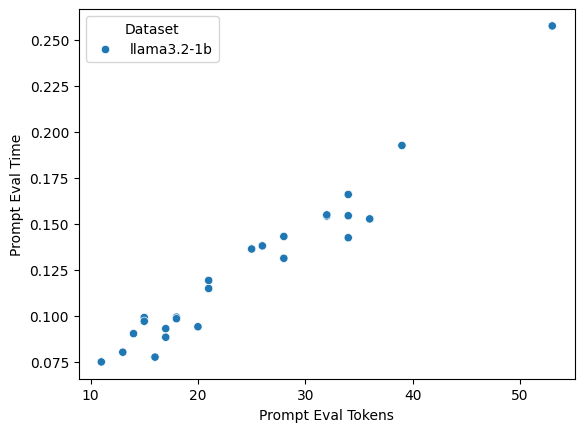

In [9]:
sns.scatterplot(data=grouped_data, x='Prompt Eval Tokens', y='Prompt Eval Time', hue='Dataset')


<Axes: xlabel='Eval Tokens', ylabel='Eval Time'>

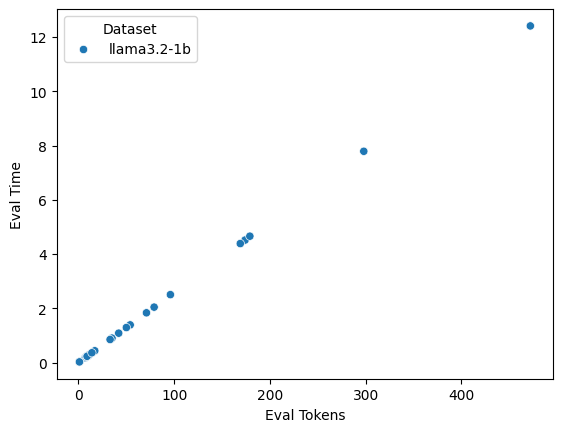

In [10]:
sns.scatterplot(data=grouped_data, x='Eval Tokens', y='Eval Time', hue='Dataset')


<Axes: xlabel='Eval Tokens', ylabel='Total Time'>

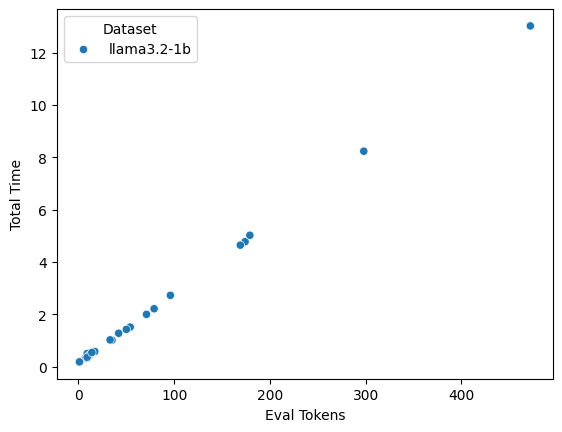

In [11]:
sns.scatterplot(data=grouped_data, x='Eval Tokens', y='Total Time', hue='Dataset')

<Axes: xlabel='Finish Reason', ylabel='count'>

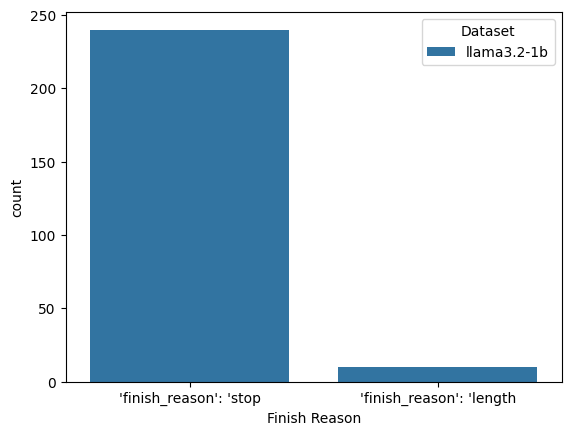

In [12]:
sns.countplot(data=combined_dataframe, x='Finish Reason', hue='Dataset')

([<matplotlib.patches.Wedge at 0x24342e41fd0>,
 [Text(-1.0913261764425057, 0.13786651736872452, "'finish_reason': 'stop"),
  Text(1.091326188495176, -0.13786642196195578, "'finish_reason': 'length")],
 [Text(-0.595268823514094, 0.07519991856475883, '96.0%'),
  Text(0.5952688300882777, -0.07519986652470315, '4.0%')])

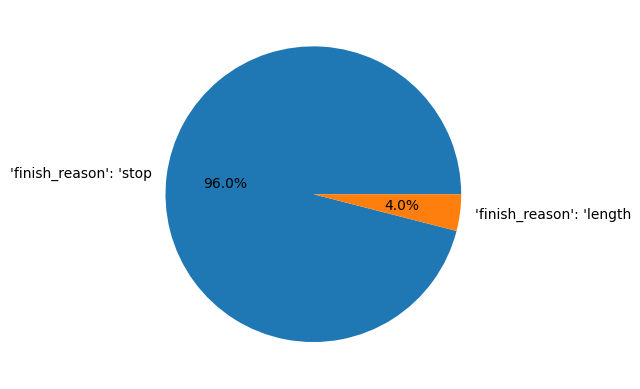

In [13]:
# This requires matplotlib.pyplot, usually imported as plt

plt.pie(combined_dataframe['Finish Reason'].value_counts(), labels=combined_dataframe['Finish Reason'].value_counts().index, autopct='%1.1f%%')


<Axes: xlabel='Total Time', ylabel='Count'>

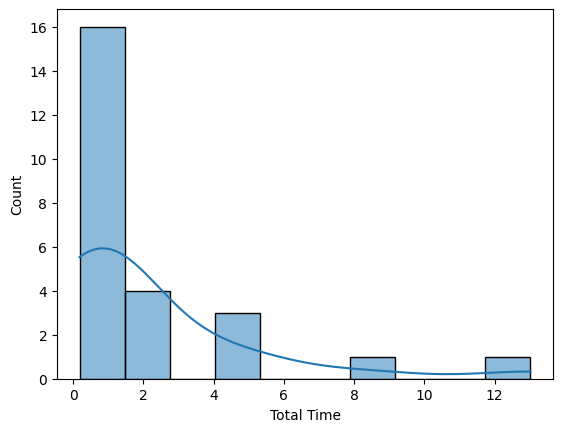

In [14]:
#sns.histplot(data=grouped_data, x='Total Time', kde=True, hue='Dataset')
sns.histplot(data=grouped_data, x='Total Time', kde=True)

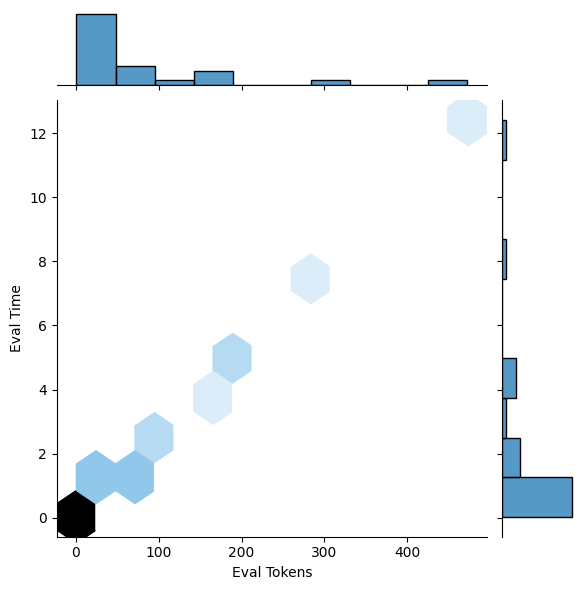

In [15]:
sns.jointplot(data=grouped_data, x='Eval Tokens', y='Eval Time', kind='hex')


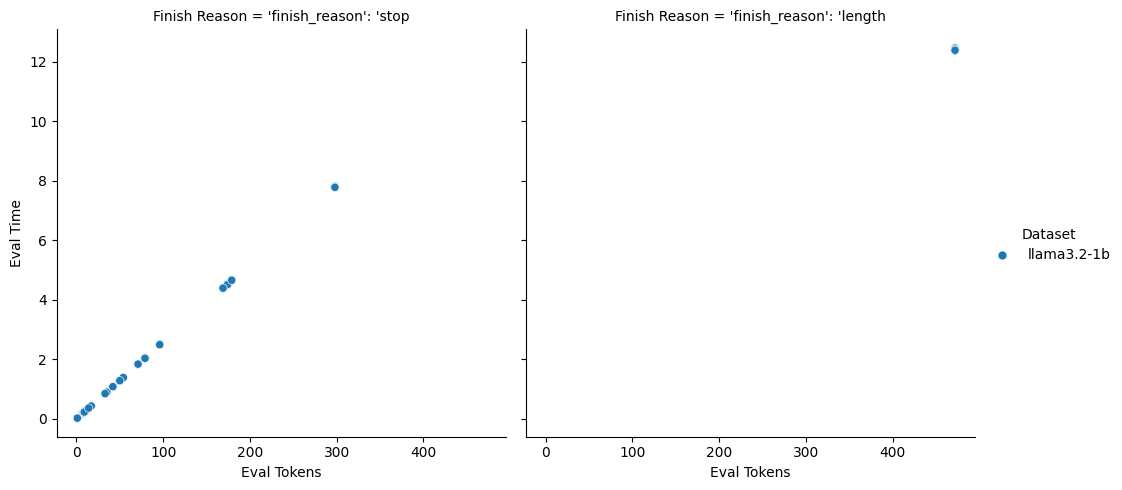

In [16]:
sns.relplot(data=combined_dataframe, x='Eval Tokens', y='Eval Time', col='Finish Reason', kind='scatter', hue='Dataset')

In [17]:
summary_stats = combined_dataframe.groupby('Dataset')['Total Time'].agg(['mean', 'median', 'std']).reset_index()

summary_stats

,Dataset,mean,median,std
0,llama3.2-1b,2.138418,1.0144,2.965544


In [18]:
duplicates = grouped_data.duplicated(subset = 'Total Time')
print("Duplicates found:", duplicates.sum())

Duplicates found: 0


<Axes: xlabel='Eval Tokens', ylabel='Count'>

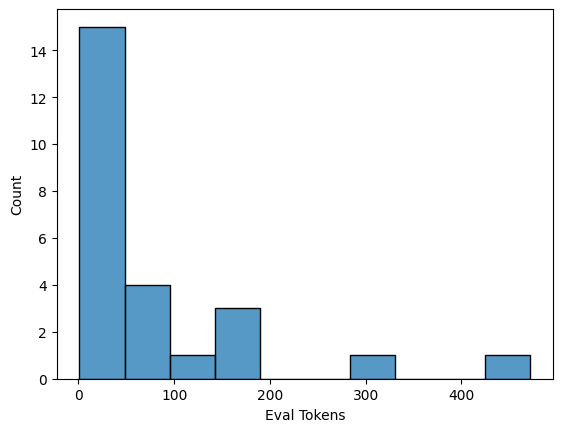

In [19]:
sns.histplot(data=grouped_data, x='Eval Tokens')

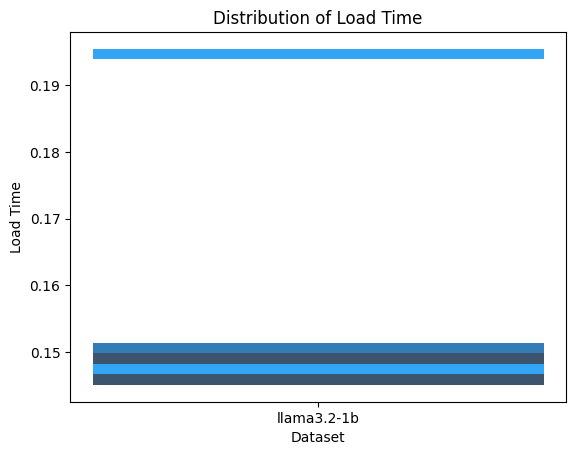

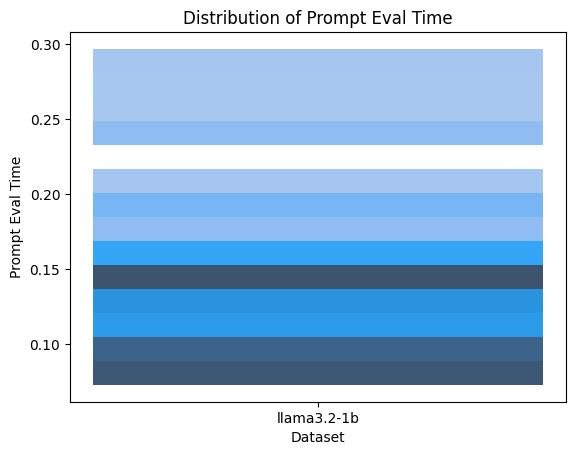

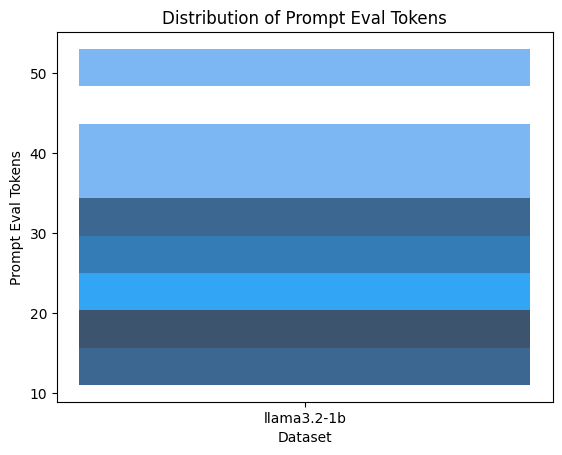

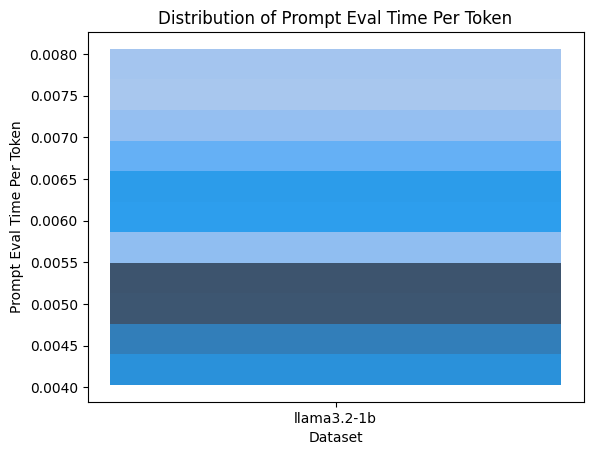

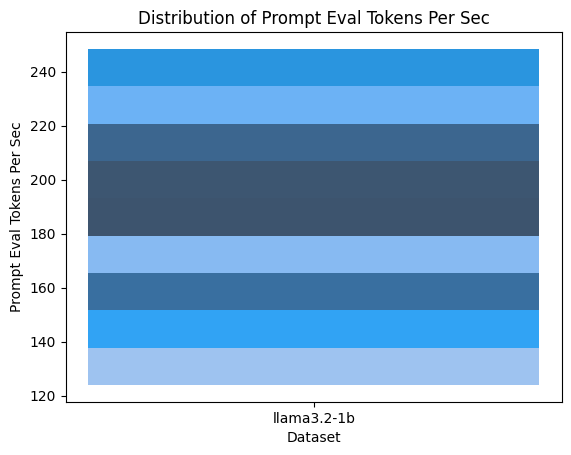

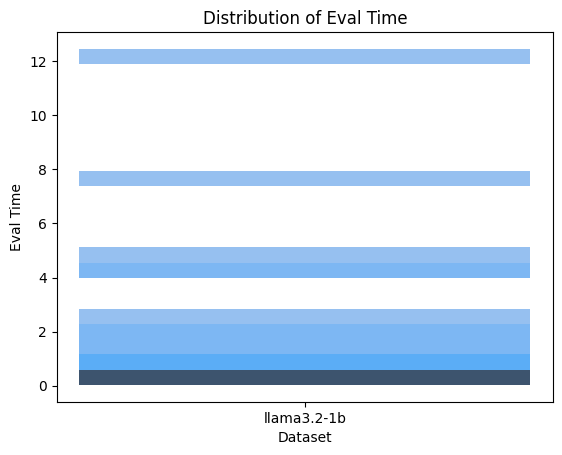

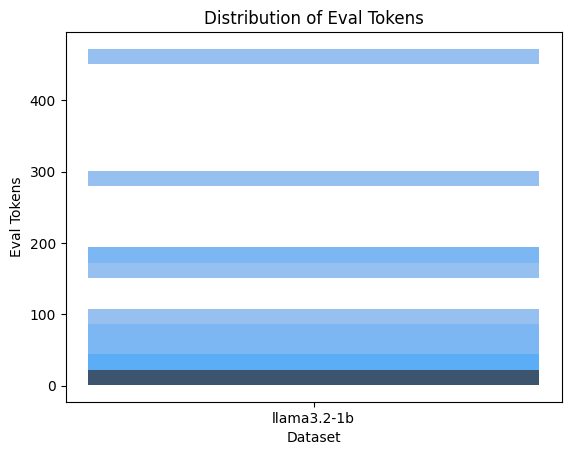

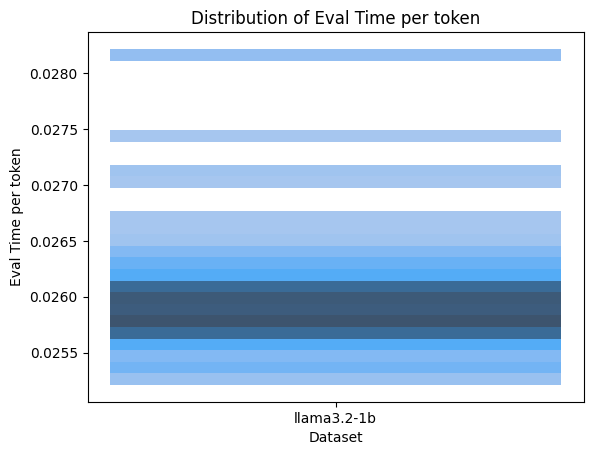

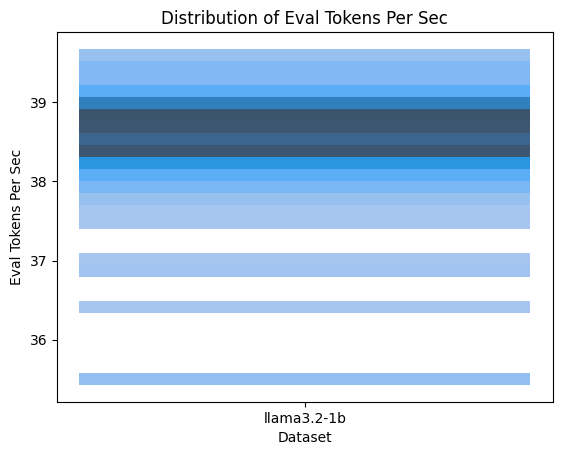

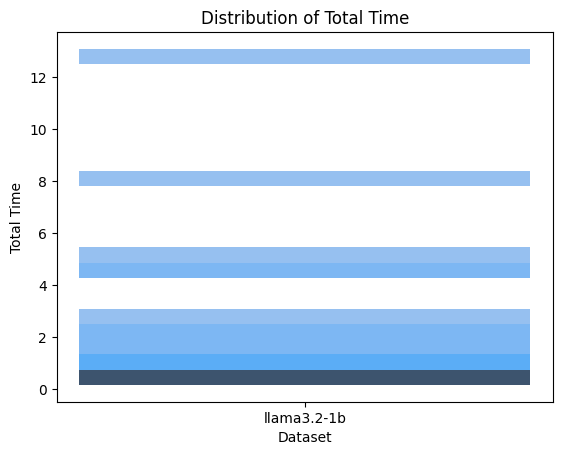

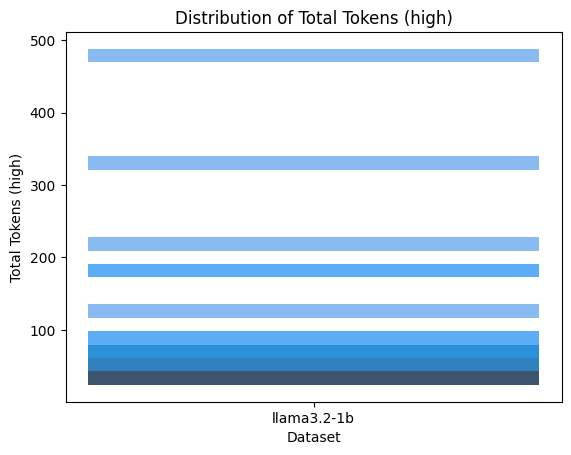

In [ ]:
for col_name in grouped_data.columns:
    if col_name not in ['Dataset', 'Prompt']:
        sns.histplot(data=combined_dataframe, y=col_name)
        plt.title(f'Distribution of {col_name}')
        plt.show()

